# Preprocessing & Exploratory Data Analysis

Brief: Notebook for preprocessing and exploring the processed trip data files.

- Objectives:
  - Load processed trip data
  - Explore station-level summaries
  - Analyze monthly trends
  - Create visualizations
  - Generate insights

In [3]:
# Common imports
import os
import sys
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)
sns.set_theme(style="whitegrid")

# Project paths
PROJECT_ROOT = Path('/Users/shirley/Documents/Research/demand/parkchargebike')
TRIP_DIR = PROJECT_ROOT / 'trip'
CODE_DIR = PROJECT_ROOT / 'code'

print(f"Project root: {PROJECT_ROOT}")
print(f"Trip dir: {TRIP_DIR}")
print(f"Code dir: {CODE_DIR}")

Project root: /Users/shirley/Documents/Research/demand/parkchargebike
Trip dir: /Users/shirley/Documents/Research/demand/parkchargebike/trip
Code dir: /Users/shirley/Documents/Research/demand/parkchargebike/code


In [ ]:
# Install required packages into the current Jupyter kernel (virtual environment)
%pip install -q folium selenium webdriver-manager pillow
print("Dependencies installed in current kernel.")


In [4]:
# List all files in trip directory
trip_files = list(TRIP_DIR.glob('*.csv'))
print(f"Found {len(trip_files)} CSV files in trip directory:")
for file in sorted(trip_files):
    print(f"  - {file.name}")

Found 55 CSV files in trip directory:
  - 202101-station-summary.csv
  - 202102-station-summary.csv
  - 202103-station-summary.csv
  - 202104-station-summary.csv
  - 202105-station-summary.csv
  - 202106-station-summary.csv
  - 202107-station-summary.csv
  - 202108-station-summary.csv
  - 202109-station-summary.csv
  - 202110-station-summary.csv
  - 202111-station-summary.csv
  - 202112-station-summary.csv
  - 202201-station-summary.csv
  - 202202-station-summary.csv
  - 202203-station-summary.csv
  - 202204-station-summary.csv
  - 202205-station-summary.csv
  - 202206-station-summary.csv
  - 202207-station-summary.csv
  - 202208-station-summary.csv
  - 202209-station-summary.csv
  - 202210-station-summary.csv
  - 202211-station-summary.csv
  - 202212-station-summary.csv
  - 202301-station-summary.csv
  - 202302-station-summary.csv
  - 202303-station-summary.csv
  - 202304-station-summary.csv
  - 202305-station-summary.csv
  - 202306-station-summary.csv
  - 202307-station-summary.csv
 

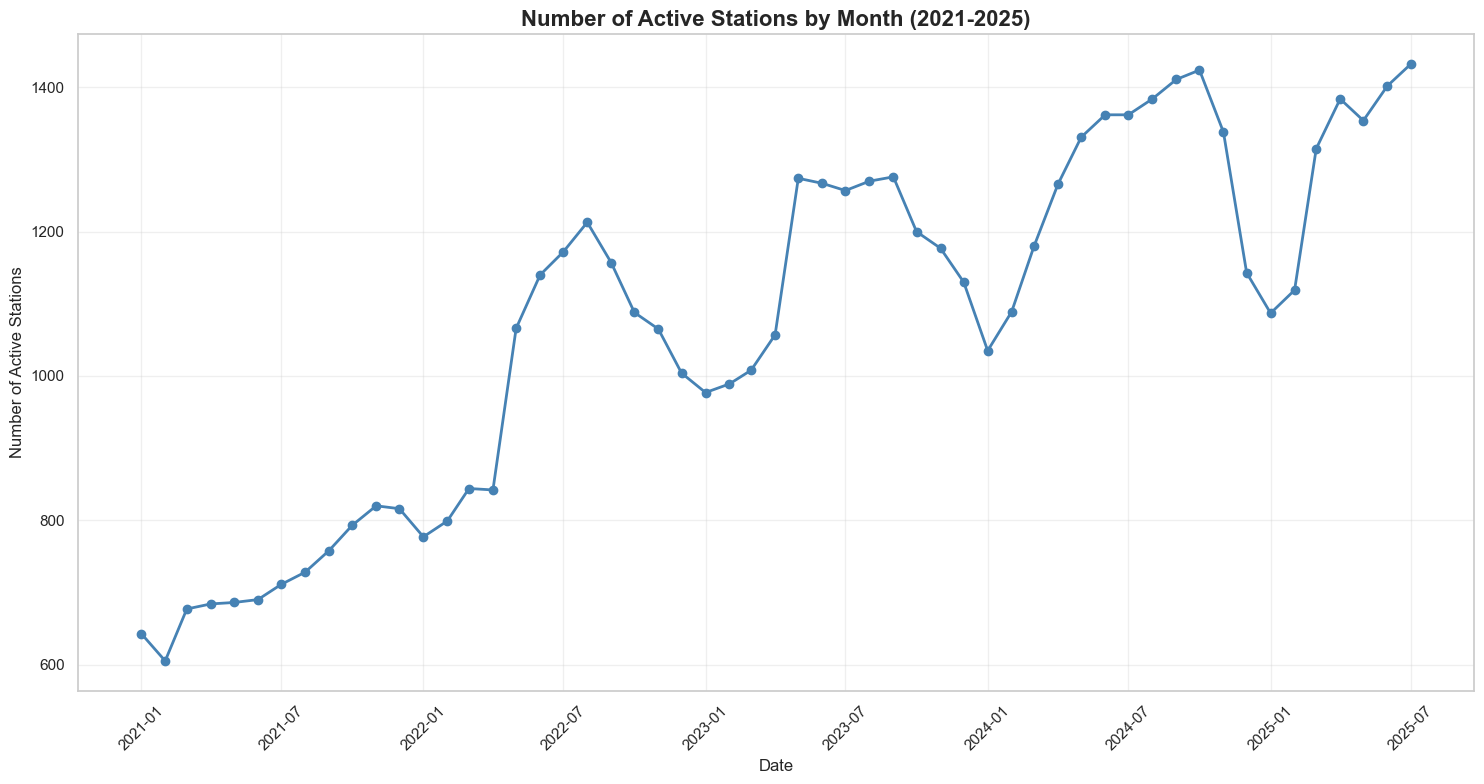

Summary Statistics:
Total months: 55
Average active stations: 1074
Min active stations: 605
Max active stations: 1432
Standard deviation: 247

Monthly Active Stations Data:
   year  month  active_stations
0  2021      1              643
1  2021      2              605
2  2021      3              677
3  2021      4              684
4  2021      5              686
5  2021      6              690
6  2021      7              711
7  2021      8              728
8  2021      9              758
9  2021     10              793


In [3]:
# Load monthly active stations data and create plot
monthly_stations = pd.read_csv(TRIP_DIR / 'monthly-active-stations.csv')

# Create datetime column for better plotting
monthly_stations['date'] = pd.to_datetime(monthly_stations[['year', 'month']].assign(day=1))

# Plot active stations by month
plt.figure(figsize=(15, 8))
plt.plot(monthly_stations['date'], monthly_stations['active_stations'], 
         marker='o', linewidth=2, markersize=6, color='steelblue')

plt.title('Number of Active Stations by Month (2021-2025)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Active Stations', fontsize=12)
plt.grid(True, alpha=0.3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add some styling
plt.tight_layout()
plt.show()

# Display summary statistics
print("Summary Statistics:")
print(f"Total months: {len(monthly_stations)}")
print(f"Average active stations: {monthly_stations['active_stations'].mean():.0f}")
print(f"Min active stations: {monthly_stations['active_stations'].min()}")
print(f"Max active stations: {monthly_stations['active_stations'].max()}")
print(f"Standard deviation: {monthly_stations['active_stations'].std():.0f}")

# Show the data
print("\nMonthly Active Stations Data:")
print(monthly_stations[['year', 'month', 'active_stations']].head(10))

In [11]:
# Build and display July maps inline (no file outputs)
import folium
import pandas as pd
from IPython.display import display, HTML

RESULT_DIR = PROJECT_ROOT / 'result'
MASTER_STATIONS_CSV = RESULT_DIR / 'master_stations.csv'

stations_df = pd.read_csv(MASTER_STATIONS_CSV)
stations_df['lat'] = pd.to_numeric(stations_df['lat'], errors='coerce')
stations_df['lng'] = pd.to_numeric(stations_df['lng'], errors='coerce')
stations_df = stations_df.dropna(subset=['lat', 'lng'])

def build_july_map(year: int) -> folium.Map:
    cur_col = f"{year}07"
    if cur_col not in stations_df.columns:
        raise KeyError(f"Column {cur_col} not found in master_stations.csv")
    prev_col = f"{year-1}07"

    cur_active = stations_df[stations_df[cur_col] == 1].copy()

    # Determine new vs existing: new stations have value 1 this year but 0 in ALL previous years
    # Special case: July 2021 has no previous years, so all stations are existing (blue)
    if year == 2021:
        is_new = pd.Series([False] * len(stations_df), index=stations_df.index)  # No new stations in 2021
    else:
        is_new = (stations_df[cur_col] == 1)
        
        # Check all previous years (2021-2024 for 2025, etc.)
        for prev_year in range(2021, year):
            prev_col = f"{prev_year}07"
            if prev_col in stations_df.columns:
                is_new = is_new & (stations_df[prev_col] == 0)

    new_stations = stations_df[is_new].copy()
    existing_stations = cur_active.merge(new_stations[['station_id']], on='station_id', how='left', indicator=True)
    existing_stations = existing_stations[existing_stations['_merge'] == 'left_only'].drop(columns=['_merge'])

    center_lat = cur_active['lat'].mean() if len(cur_active) else 41.8781
    center_lng = cur_active['lng'].mean() if len(cur_active) else -87.6298

    fmap = folium.Map(location=[center_lat, center_lng], zoom_start=11, tiles='cartodbpositron', control_scale=True)

    # Feature groups for legend toggling
    fg_existing = folium.FeatureGroup(name='Existing', show=True)
    fg_new = folium.FeatureGroup(name='New', show=True)

    for _, row in existing_stations.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=4,
            color='#1f77b4',
            fill=True,
            fill_color='#1f77b4',
            fill_opacity=0.7,
            popup=f"{row['station_name']} (ID: {row['station_id']})",
        ).add_to(fg_existing)

    for _, row in new_stations.iterrows():
        folium.CircleMarker(
            location=[row['lat'], row['lng']],
            radius=5,
            color='#d62728',
            fill=True,
            fill_color='#d62728',
            fill_opacity=0.85,
            popup=f"NEW: {row['station_name']} (ID: {row['station_id']})",
        ).add_to(fg_new)

    fg_existing.add_to(fmap)
    fg_new.add_to(fmap)
    folium.LayerControl(collapsed=False).add_to(fmap)

    return fmap

for yr in [2021, 2022, 2023, 2024, 2025]:
    display(HTML(f"<h3 style='margin:8px 0;'>Active Stations - {yr}-07</h3>"))
    display(build_july_map(yr))
